In [1]:
import asyncio
import os

from collections import Counter
from datetime import datetime
from pathlib import Path

import duckdb
import httpx
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

%load_ext sql

from dotenv import load_dotenv

load_dotenv()

DB_PATH = Path(".").absolute().parent / Path(os.getenv("SILVER_DUCKDB_PATH", ""))

TMP_DIR = "/tmp/duckdb_tmp"

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

NODES_CSV = OUT_DIR / "senado_bipartite_nodes.csv"
EDGES_CSV = OUT_DIR / "senado_bipartite_edges.csv"

conn = duckdb.connect(DB_PATH)

conn.execute(f"SET temp_directory='{TMP_DIR}'")
conn.execute("SET memory_limit='50GB'")
conn.execute("SET threads=1")
conn.execute("SET preserve_insertion_order=false")

plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.figsize"] = (6, 4)
sns.set_style("darkgrid")

%sql conn --alias duck


Tip: You may define configurations in /home/c-cc2016/ra173608/tramita/pyproject.toml or /home/c-cc2016/ra173608/.jupysql/config.

Did not find user configurations in /home/c-cc2016/ra173608/tramita/pyproject.toml.

# Carregamento dos dados

## Processos

In [2]:
proc_df = conn.execute("SELECT * FROM processo_senado").df()
proc_df.head()

,id_processo,codigo_materia,id_processo_casa_inicial,identificacao,identificacao_processo_inicial,identificacao_externa,ano,casa_identificadora,sigla_casa_iniciadora,sigla_ente_identificador,...,norma_sigla_tipo,norma_tipo,norma_descricao,norma_sigla_veiculo,norma_veiculo,norma_numero_int,norma_ano_assinatura,norma_data_assinatura,norma_data_publicacao,year_snapshot
0,502664,124528,502661,PLC 215/2015,PL 546/2003,{},2015,SF,CD,SF,...,None,None,None,None,None,<NA>,<NA>,NaT,NaT,2015
1,502818,124522,502815,PLC 217/2015,PL 3019/2008,{},2015,SF,CD,SF,...,None,None,None,None,None,<NA>,<NA>,NaT,NaT,2015
2,502857,124521,502854,PLC 218/2015,PL 1611/2011,{},2015,SF,CD,SF,...,None,None,None,None,None,<NA>,<NA>,NaT,NaT,2015
3,502935,124515,502932,PLC 216/2015,PL 4642/2004,{},2015,SF,CD,SF,...,None,None,None,None,None,<NA>,<NA>,NaT,NaT,2015
4,503091,124412,503088,PLC 207/2015,PL 1511/2011,{},2015,SF,CD,SF,...,None,None,None,None,None,<NA>,<NA>,NaT,NaT,2015


In [3]:
proc_df = proc_df[[
    'id_processo',
    'codigo_materia',
    'identificacao',
    'identificacao_processo_inicial',
    'ano',
    'casa_identificadora',
    'sigla_casa_iniciadora',
    'sigla_ente_identificador',
    'documento_sigla_tipo',
    'documento_resumo_autoria',
]]

In [4]:
proc_df['documento_sigla_tipo'].unique()

array(['PROJETO_LEI_ORDINARIA', 'PROJETO_LEI_COMPLEMENTAR',
       'PROJETO_DECRETO_LEGISLATIVO', 'PROJETO_RESOLUCAO',
       'PROPOSTA_EMENDA_CONSTITUICAO', 'INDICACAO',
       'PROPOSTA_FISCALIZACAO_CONTROLE', 'REQUERIMENTO', 'SUGESTAO',
       'AVISO', 'MENSAGEM', 'EMENDA', 'OFICIO', 'PETICAO',
       'MEDIDA_PROVISORIA', 'RECURSO', 'ATO', 'DENUNCIA'], dtype=object)

In [5]:
ALLOWED_TYPES = [
    'PROJETO_LEI_ORDINARIA',
    'PROJETO_LEI_COMPLEMENTAR',
    'PROPOSTA_EMENDA_CONSTITUICAO',
    'MEDIDA_PROVISORIA',
]

In [6]:
proc_df = proc_df[proc_df['documento_sigla_tipo'].isin(ALLOWED_TYPES)]
proc_df.head()

,id_processo,codigo_materia,identificacao,identificacao_processo_inicial,ano,casa_identificadora,sigla_casa_iniciadora,sigla_ente_identificador,documento_sigla_tipo,documento_resumo_autoria
0,502664,124528,PLC 215/2015,PL 546/2003,2015,SF,CD,SF,PROJETO_LEI_ORDINARIA,Câmara dos Deputados
1,502818,124522,PLC 217/2015,PL 3019/2008,2015,SF,CD,SF,PROJETO_LEI_ORDINARIA,Câmara dos Deputados
2,502857,124521,PLC 218/2015,PL 1611/2011,2015,SF,CD,SF,PROJETO_LEI_ORDINARIA,Câmara dos Deputados
3,502935,124515,PLC 216/2015,PL 4642/2004,2015,SF,CD,SF,PROJETO_LEI_ORDINARIA,Câmara dos Deputados
4,503091,124412,PLC 207/2015,PL 1511/2011,2015,SF,CD,SF,PROJETO_LEI_ORDINARIA,Câmara dos Deputados


In [7]:
auth_doc_df = conn.execute("SELECT * FROM documento_autoria_senado").df()
auth_doc_df = auth_doc_df[auth_doc_df['id_processo'].isin(proc_df['id_processo'])]
auth_doc_df.head()

,id_documento_autoria,id_processo,id_ente,autor,codigo_parlamentar,descricao_tipo,ente,ordem,outros_autores_nao_informados,sigla_ente,sigla_tipo,year_snapshot
0,1,2526458,55126,Presidência da República,<NA>,PRESIDENTE_REPUBLICA,Presidência da República,1,Não,PR,PRESIDENTE_REPUBLICA,2001
1,2,663587,1,Paulo Paim,825,SENADOR,Senado Federal,1,Não,SF,SENADOR,2005
3,4,2978567,1,Paulo Paim,825,SENADOR,Senado Federal,1,Não,SF,SENADOR,2007
4,5,2968939,1,Paulo Paim,825,SENADOR,Senado Federal,1,Não,SF,SENADOR,2008
5,6,2970890,1,Alvaro Dias,945,SENADOR,Senado Federal,1,Não,SF,SENADOR,2008


In [8]:
async with httpx.AsyncClient() as client:
    response = await client.get("https://legis.senado.leg.br/dadosabertos/processo/entes")
    response.raise_for_status()
    data = response.json()

In [9]:
entes_df = pd.DataFrame(data)
entes_df = entes_df.set_index('id', drop=True)
entes_df.head()

,sigla,nome,casa,siglaTipo,descricaoTipo,dataInicio,dataFim
id,,,,,,,
7378493,None,1ª Câmara de Coordenação e Revisão -Direitos S...,None,ENTE_JURIDICO,Ente Jurídico - não categorizado,None,None
7378350,None,1ª Câmara de Coordenação e Revisão do Ministér...,None,ENTE_JURIDICO,Ente Jurídico - não categorizado,None,None
301,None,1º Vice-Presidente da Mesa do Congresso Nacion...,None,ENTE_JURIDICO,Ente Jurídico - não categorizado,None,None
7376109,None,"2ª Vara Cível, Família e Sucessões Inf. e Juve...",None,ENTE_JURIDICO,Ente Jurídico - não categorizado,None,None
7376147,None,"2ª Vara de Família, Sucessões, Órfãos, Interdi...",None,ENTE_JURIDICO,Ente Jurídico - não categorizado,None,None


In [10]:
def make_auth_label(row: pd.Series):
    if row['sigla_tipo'] == "SENADOR":
        return f"S:{row['codigo_parlamentar']}"
    if pd.notna(row['id_ente']):
        return f"O:{row['id_ente']}"
    # comissão do congresso
    return f"O:CC"

    
auth_doc_df['auth_tag'] = auth_doc_df.apply(make_auth_label, axis=1)
auth_df = auth_doc_df[['id_processo', 'id_ente', 'descricao_tipo', 'sigla_ente', 'sigla_tipo', 'auth_tag']]
auth_df.head()

,id_processo,id_ente,descricao_tipo,sigla_ente,sigla_tipo,auth_tag
0,2526458,55126,PRESIDENTE_REPUBLICA,PR,PRESIDENTE_REPUBLICA,O:55126
1,663587,1,SENADOR,SF,SENADOR,S:825
3,2978567,1,SENADOR,SF,SENADOR,S:825
4,2968939,1,SENADOR,SF,SENADOR,S:825
5,2970890,1,SENADOR,SF,SENADOR,S:945


In [11]:
auth_df[['descricao_tipo', 'sigla_ente', 'sigla_tipo']].value_counts()

descricao_tipo            sigla_ente   sigla_tipo              
SENADOR                   SF           SENADOR                     9288
CAMARA                    CD           CAMARA                       950
PRESIDENTE_REPUBLICA      PR           PRESIDENTE_REPUBLICA         572
COMISSAO_SENADO           CPIMT        COMISSAO_SENADO               30
COMISSAO_SENADO_SENADOR   SF           COMISSAO_SENADO_SENADOR       27
COMISSAO_SENADO           CDH          COMISSAO_SENADO               25
DEPUTADO                  CD           DEPUTADO                       5
COMISSAO_SENADO           CPIPANDEMIA  COMISSAO_SENADO                5
                          CDIR         COMISSAO_SENADO                4
                          CPIDFDQ      COMISSAO_SENADO                4
                          CPIPREV      COMISSAO_SENADO                3
                          CPICC        COMISSAO_SENADO                3
                          CPIADJ       COMISSAO_SENADO                2


In [12]:
def auth_category(row: pd.Series):
    if row['sigla_ente'] in ('SF', 'CD', 'PR'):
        return row['sigla_ente']
    if row['sigla_tipo'] == "COMISSAO_CONGRESSO":
        return "CN"
    if row['descricao_tipo'] == "ASSEMBLEIAS_LEGISLATIVAS":
        return "AL"
    if "CAMARA" in row['descricao_tipo'] or "CAMARA" in row['sigla_tipo']:
        return "CD"
    if "COMISSAO" in row['sigla_tipo']:
        return "SF"
    if row['sigla_tipo'] == "SENADO":
        return "SF"
    return "what"

In [13]:
auth_df['auth_category'] = auth_df.apply(auth_category, axis=1)

/tmp/ipykernel_1068638/3776278057.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auth_df['auth_category'] = auth_df.apply(auth_category, axis=1)


In [14]:
auth_df['auth_category'].unique()

array(['PR', 'SF', 'CD', 'AL', 'CN'], dtype=object)

In [15]:
auth_df['auth_supercategory'] = auth_df['auth_category'].apply(lambda v: "OUTROS" if v in ("AL", "CN") else v)
auth_df

/tmp/ipykernel_1068638/3903558055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auth_df['auth_supercategory'] = auth_df['auth_category'].apply(lambda v: "OUTROS" if v in ("AL", "CN") else v)


,id_processo,id_ente,descricao_tipo,sigla_ente,sigla_tipo,auth_tag,auth_category,auth_supercategory
0,2526458,55126,PRESIDENTE_REPUBLICA,PR,PRESIDENTE_REPUBLICA,O:55126,PR,PR
1,663587,1,SENADOR,SF,SENADOR,S:825,SF,SF
3,2978567,1,SENADOR,SF,SENADOR,S:825,SF,SF
4,2968939,1,SENADOR,SF,SENADOR,S:825,SF,SF
5,2970890,1,SENADOR,SF,SENADOR,S:945,SF,SF
...,...,...,...,...,...,...,...,...
36437,8730961,1,SENADOR,SF,SENADOR,S:6335,SF,SF
36447,8730961,1,SENADOR,SF,SENADOR,S:5502,SF,SF
36457,8730961,1,SENADOR,SF,SENADOR,S:6341,SF,SF
36467,8730961,1,SENADOR,SF,SENADOR,S:6009,SF,SF


In [16]:
senator_df = conn.execute("SELECT * FROM parlamentar_senado").df()
senator_df = senator_df.set_index('codigo_parlamentar', drop=True)
senator_df.head()

,codigo_publico_leg_atual,nome_completo,nome_parlamentar,sexo_parlamentar,sigla_partido,uf_parlamentar,email_parlamentar,data_nascimento,endereco_parlamentar,naturalidade,uf_naturalidade,year_snapshot,rn
codigo_parlamentar,,,,,,,,,,,,,
4606,<NA>,José Eleonildo Soares,Pinto Itamaraty,Masculino,PSDB,None,pinto.itamaraty@senador.leg.br,1960-05-10,Senado Federal Anexo I 25º Andar,São Luís,MA,2023,1
4811,900,Laércio José de Oliveira,Laércio Oliveira,Masculino,PP,SE,sen.laerciooliveira@senado.leg.br,1959-04-15,Senado Federal Anexo 2 Ala Teotônio Vilela G...,Recife,PE,2024,1
5257,<NA>,Renzo do Amaral Braz,Renzo Braz,Masculino,PP,None,None,1980-04-11,None,Muriaé,MG,2024,1
5537,928,Dário Elias Berger,Dário Berger,Masculino,PSB,None,sen.darioberger@senado.leg.br,1956-12-07,Senado Federal Anexo 1 16º Pavimento,Bom Retiro,SC,2023,1
5615,<NA>,Gilberto Piselo do Nascimento,Gilberto Piselo,Masculino,PDT,None,None,1959-07-04,None,None,None,2023,1


### Checagem de autores órfãos (indexados na relacional mas sem presença no BD)

In [17]:
# Faltaram vários senadores na tabela, então vamos puxar novamente

senator_ids = set(int(v) for v in auth_df[auth_df['auth_tag'].str.startswith("S")]['auth_tag'].str.slice(2))
senator_ids = sorted(senator_ids)

In [18]:
async def get_senator(sid, sem: asyncio.Semaphore, client: httpx.AsyncClient):
    async with sem:
        print(sid)
        response = await client.get(f"https://legis.senado.leg.br/dadosabertos/senador/{sid}.json")
        response.raise_for_status()
        data = response.json()
        return data

sem = asyncio.Semaphore(4)
results = []
async with httpx.AsyncClient() as client:
    for i in range(0, len(senator_ids), 5):
        tasks = [get_senator(sid, sem, client) for sid in senator_ids[i:i+5]]
        result = await asyncio.gather(*tasks, return_exceptions=True)
        if isinstance(result, Exception):
            assert False
        results.extend(result)
        await asyncio.sleep(1)
    

3
13
16
17
20
22
35
40
64
68
70
72
73
87
90
111
151
285
345
374
391
456
470
475
558
581
604
611
612
613
615
631
635
643
677
715
739
742
751
765
825
846
878
945
950
952
1023
1173
1176
1186
1210
1249
2207
2331
2632
3360
3361
3366
3372
3394
3396
3398
3399
3579
3634
3695
3713
3741
3777
3806
3823
3830
4522
4525
4527
4529
4531
4537
4539
4541
4545
4558
4560
4575
4593
4605
4606
4610
4639
4642
4645
4694
4697
4721
4763
4767
4770
4772
4776
4786
4811
4837
4869
4873
4877
4893
4895
4935
4937
4969
4981
4988
4990
4994
5000
5002
5004
5006
5008
5010
5012
5016
5018
5020
5030
5038
5048
5052
5070
5072
5076
5100
5106
5108
5110
5112
5116
5132
5140
5144
5150
5158
5164
5178
5182
5184
5197
5199
5236
5281
5322
5350
5352
5376
5385
5386
5411
5422
5502
5523
5525
5527
5529
5531
5533
5535
5537
5540
5557
5561
5585
5617
5619
5621
5627
5635
5637
5639
5666
5672
5718
5732
5736
5740
5748
5783
5793
5849
5894
5895
5898
5899
5902
5905
5906
5913
5917
5924
5926
5927
5929
5936
5942
5953
5959
5967
5971
5972
5973
5976
5979
5982
59

In [19]:
rows = [
    {
        'codigo_parlamentar': int(r['DetalheParlamentar']['Parlamentar']['IdentificacaoParlamentar']['CodigoParlamentar']),
        'nome_parlamentar': r['DetalheParlamentar']['Parlamentar']['IdentificacaoParlamentar']['NomeParlamentar'],
    }
    for r in results
]

In [20]:
sen_df = pd.DataFrame(rows)

In [21]:
sen_df = sen_df.set_index('codigo_parlamentar', drop=True)
sen_df.head()

,nome_parlamentar
codigo_parlamentar,
3,Antonio Carlos Valadares
13,Casildo Maldaner
16,Edison Lobão
17,Eduardo Suplicy
20,Epitácio Cafeteira


In [22]:
def get_auth_label(auth_tag):
    if auth_tag == "O:CC":
        return "Comissão do Congresso Nacional"
    if auth_tag.startswith("O"):
        eid = int(auth_tag[2:])
        return entes_df.loc[eid, 'nome']
    if auth_tag.startswith("S"):
        sid = int(auth_tag[2:])
        return sen_df.loc[sid, 'nome_parlamentar']

In [23]:
auth_df['auth_label'] = auth_df['auth_tag'].apply(get_auth_label)

/tmp/ipykernel_1068638/3261863448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auth_df['auth_label'] = auth_df['auth_tag'].apply(get_auth_label)


In [24]:
auth_df

,id_processo,id_ente,descricao_tipo,sigla_ente,sigla_tipo,auth_tag,auth_category,auth_supercategory,auth_label
0,2526458,55126,PRESIDENTE_REPUBLICA,PR,PRESIDENTE_REPUBLICA,O:55126,PR,PR,Presidência da República
1,663587,1,SENADOR,SF,SENADOR,S:825,SF,SF,Paulo Paim
3,2978567,1,SENADOR,SF,SENADOR,S:825,SF,SF,Paulo Paim
4,2968939,1,SENADOR,SF,SENADOR,S:825,SF,SF,Paulo Paim
5,2970890,1,SENADOR,SF,SENADOR,S:945,SF,SF,Alvaro Dias
...,...,...,...,...,...,...,...,...,...
36437,8730961,1,SENADOR,SF,SENADOR,S:6335,SF,SF,Damares Alves
36447,8730961,1,SENADOR,SF,SENADOR,S:5502,SF,SF,Plínio Valério
36457,8730961,1,SENADOR,SF,SENADOR,S:6341,SF,SF,Hamilton Mourão
36467,8730961,1,SENADOR,SF,SENADOR,S:6009,SF,SF,Astronauta Marcos Pontes


# Montagem dos dataframes finais para produção dos grafos

In [25]:
proc_df['proc_tag'] = proc_df['id_processo'].apply(lambda v: f"P:{v}")
proc_df['proc_label'] = proc_df['identificacao']



In [26]:
def get_proc_type(v):
    return {
        'PROJETO_LEI_ORDINARIA': 'PL',
        'PROJETO_LEI_COMPLEMENTAR': 'PL',
        'PROPOSTA_EMENDA_CONSTITUICAO': 'PEC',
        'MEDIDA_PROVISORIA': 'MP',
    }[v]
proc_df['proc_category'] = proc_df['documento_sigla_tipo'].apply(get_proc_type)

In [27]:


proc_df = proc_df[['id_processo', 'identificacao', 'identificacao_processo_inicial', 'proc_tag', 'proc_label', 'proc_category']]

In [28]:
proc_df = proc_df.set_index('id_processo', drop=True)
proc_df

,identificacao,identificacao_processo_inicial,proc_tag,proc_label,proc_category
id_processo,,,,,
502664,PLC 215/2015,PL 546/2003,P:502664,PLC 215/2015,PL
502818,PLC 217/2015,PL 3019/2008,P:502818,PLC 217/2015,PL
502857,PLC 218/2015,PL 1611/2011,P:502857,PLC 218/2015,PL
502935,PLC 216/2015,PL 4642/2004,P:502935,PLC 216/2015,PL
503091,PLC 207/2015,PL 1511/2011,P:503091,PLC 207/2015,PL
...,...,...,...,...,...
2927961,PLS 21/2014,PLS 21/2014,P:2927961,PLS 21/2014,PL
3037890,PEC 56/2014,PEC 434/2014,P:3037890,PEC 56/2014,PEC
8780966,PEC 54/2024,PEC 31/2007,P:8780966,PEC 54/2024,PEC


In [29]:
df = auth_df.join(proc_df, on='id_processo', how='left')

In [30]:
dedup_df = df.drop_duplicates(subset=['id_processo'], keep='first')
dedup_df

,id_processo,id_ente,descricao_tipo,sigla_ente,sigla_tipo,auth_tag,auth_category,auth_supercategory,auth_label,identificacao,identificacao_processo_inicial,proc_tag,proc_label,proc_category
0,2526458,55126,PRESIDENTE_REPUBLICA,PR,PRESIDENTE_REPUBLICA,O:55126,PR,PR,Presidência da República,MPV 2224/2001,MPV 2224/2001,P:2526458,MPV 2224/2001,MP
1,663587,1,SENADOR,SF,SENADOR,S:825,SF,SF,Paulo Paim,PLS 169/2005,PLS 169/2005,P:663587,PLS 169/2005,PL
3,2978567,1,SENADOR,SF,SENADOR,S:825,SF,SF,Paulo Paim,PLS 214/2007,PLS 214/2007,P:2978567,PLS 214/2007,PL
4,2968939,1,SENADOR,SF,SENADOR,S:825,SF,SF,Paulo Paim,PLS 413/2008,PLS 413/2008,P:2968939,PLS 413/2008,PL
5,2970890,1,SENADOR,SF,SENADOR,S:945,SF,SF,Alvaro Dias,PLS 260/2008,PLS 260/2008,P:2970890,PLS 260/2008,PL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35689,8779434,2,CAMARA,CD,CAMARA,O:2,CD,CD,Câmara dos Deputados,PL 3817/2024,PL 3817/2024,P:8779434,PL 3817/2024,PL
35695,8779801,2,CAMARA,CD,CAMARA,O:2,CD,CD,Câmara dos Deputados,PLP 210/2024,PLP 210/2024,P:8779801,PLP 210/2024,PL
35705,8780966,2,CAMARA,CD,CAMARA,O:2,CD,CD,Câmara dos Deputados,PEC 54/2024,PEC 31/2007,P:8780966,PEC 54/2024,PEC
35711,8781192,2,CAMARA,CD,CAMARA,O:2,CD,CD,Câmara dos Deputados,PL 4614/2024,PL 4614/2024,P:8781192,PL 4614/2024,PL


In [31]:
pd.crosstab(dedup_df['proc_category'], dedup_df['auth_supercategory'])

auth_supercategory,CD,OUTROS,PR,SF
proc_category,,,,
MP,0,0,365,0
PEC,21,1,0,220
PL,929,8,207,2886


In [32]:
len(dedup_df)

4637

In [33]:
df[['proc_tag', 'auth_tag']]

,proc_tag,auth_tag
0,P:2526458,O:55126
1,P:663587,S:825
3,P:2978567,S:825
4,P:2968939,S:825
5,P:2970890,S:945
...,...,...
36437,P:8730961,S:6335
36447,P:8730961,S:5502
36457,P:8730961,S:6341
36467,P:8730961,S:6009


In [34]:
df[['proc_tag', 'auth_tag']].to_csv(EDGES_CSV, index=False)

In [35]:
proc_node_df = df[['proc_tag', 'proc_label']].drop_duplicates()
proc_node_df['type'] = "processo"
proc_node_df.columns = ['tag', 'label', 'type']
proc_node_df.head()

,tag,label,type
0,P:2526458,MPV 2224/2001,processo
1,P:663587,PLS 169/2005,processo
3,P:2978567,PLS 214/2007,processo
4,P:2968939,PLS 413/2008,processo
5,P:2970890,PLS 260/2008,processo


In [36]:
auth_node_df = df[['auth_tag', 'auth_label']].drop_duplicates()
auth_node_df['type'] = auth_node_df['auth_tag'].apply(lambda v: "senador" if v[0] == "S" else "orgao")
auth_node_df.columns = ['tag', 'label', 'type']
auth_node_df.head()

,tag,label,type
0,O:55126,Presidência da República,orgao
1,S:825,Paulo Paim,senador
5,S:945,Alvaro Dias,senador
10,O:2,Câmara dos Deputados,orgao
16,S:1249,Kátia Abreu,senador


In [37]:
node_df = pd.concat([auth_node_df, proc_node_df]).reset_index(drop=True)
node_df

,tag,label,type
0,O:55126,Presidência da República,orgao
1,S:825,Paulo Paim,senador
2,S:945,Alvaro Dias,senador
3,O:2,Câmara dos Deputados,orgao
4,S:1249,Kátia Abreu,senador
...,...,...,...
4907,P:8779434,PL 3817/2024,processo
4908,P:8779801,PLP 210/2024,processo
4909,P:8780966,PEC 54/2024,processo
4910,P:8781192,PL 4614/2024,processo


In [38]:
node_df.to_csv(NODES_CSV, index=False)

# Montagem dos grafos


In [39]:
nodes_df = pd.read_csv(NODES_CSV)
edges_df = pd.read_csv(EDGES_CSV)

In [40]:
G = nx.Graph()

for _, r in nodes_df.iterrows():
    G.add_node(
        r['tag'],
        label=r['label'],
        ntype=r['type'],
    )

In [41]:
for _, r in edges_df.iterrows():
    p, a = r['proc_tag'], r['auth_tag']
    G.add_edge(a, p, etype="autoria")

In [42]:
G.number_of_nodes(), G.number_of_edges()

(4912, 10926)

# Geração dos gráficos

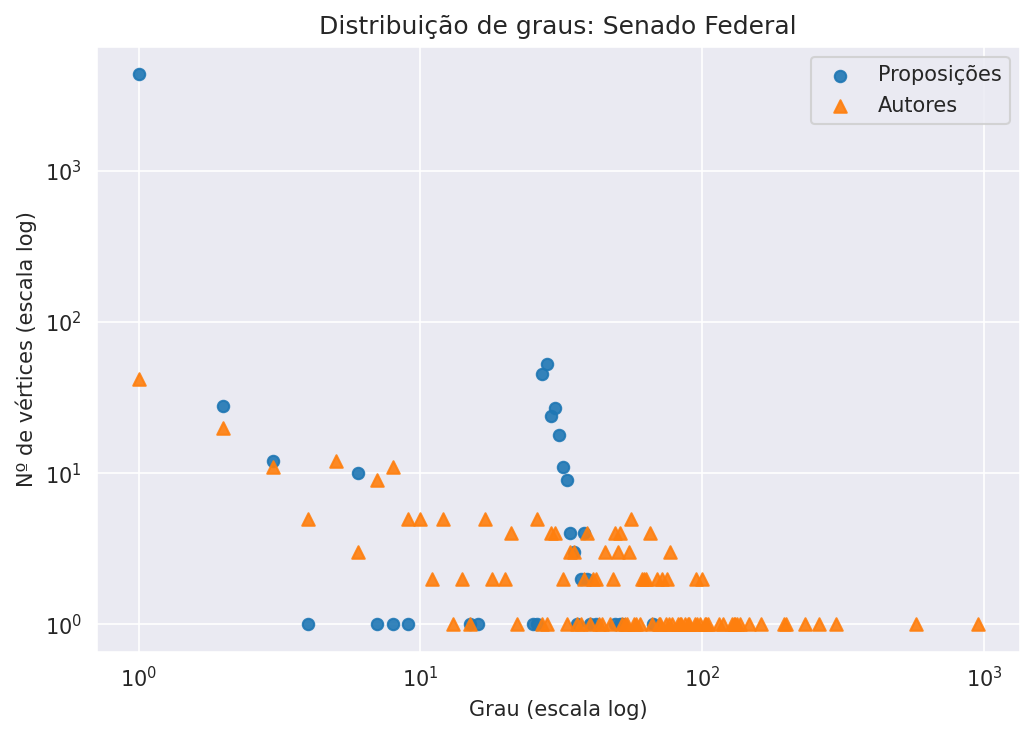

In [43]:


# Split nodes
bill_nodes   = [n for n, d in G.nodes(data=True) if n.startswith("P")]
author_nodes = [n for n, d in G.nodes(data=True) if n.startswith(("S", "O"))]

# Degree distributions
deg_bills   = Counter(dict(G.degree(bill_nodes)).values())
deg_authors = Counter(dict(G.degree(author_nodes)).values())

xs_b = sorted(deg_bills.keys())
ys_b = [deg_bills[x] for x in xs_b]

xs_a = sorted(deg_authors.keys())
ys_a = [deg_authors[x] for x in xs_a]


plt.figure(figsize=(7,5))

# Bills: circles
plt.scatter(xs_b, ys_b, marker="o", s=30, alpha=0.9, label="Proposições")

# Authors: triangles
plt.scatter(xs_a, ys_a, marker="^", s=36, alpha=0.9, label="Autores")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Grau (escala log)")
plt.ylabel("Nº de vértices (escala log)")
plt.title("Distribuição de graus: Senado Federal")
plt.legend()
plt.tight_layout()
plt.show()


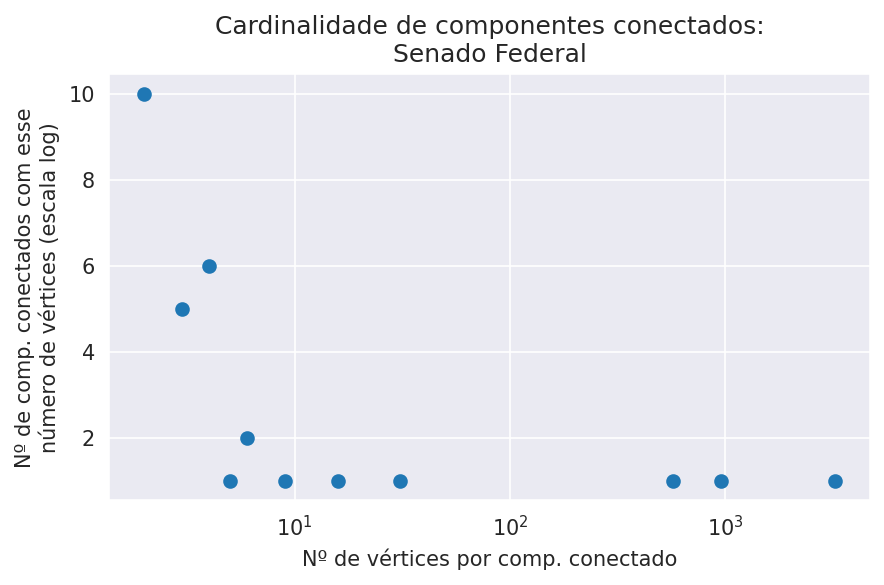

In [44]:
ccs = list(nx.connected_components(G))
cc_sizes = [len(cc) for cc in ccs]
cc_size_dist = Counter(cc_sizes)
xs = sorted(cc_size_dist.keys())
ys = [cc_size_dist[x] for x in xs]
plt.figure(figsize=(6,4))
plt.scatter(xs, ys)
plt.xlabel("Nº de vértices por comp. conectado")
plt.ylabel("Nº de comp. conectados com esse\nnúmero de vértices (escala log)")
plt.xscale("log")
# plt.yscale("log")
plt.title("Cardinalidade de componentes conectados:\nSenado Federal")
plt.tight_layout()
plt.show()

In [45]:
V = G.number_of_nodes()
E = G.number_of_edges()
k = 2 * E / V
print(f"|V| = {V}")
print(f"|E| = {E}")
print(f"<k> = {k}")
print(f"ccs = {len(ccs)}")


|V| = 4912
|E| = 10926
<k> = 4.448697068403908
ccs = 30


In [47]:
df

,id_processo,id_ente,descricao_tipo,sigla_ente,sigla_tipo,auth_tag,auth_category,auth_supercategory,auth_label,identificacao,identificacao_processo_inicial,proc_tag,proc_label,proc_category
0,2526458,55126,PRESIDENTE_REPUBLICA,PR,PRESIDENTE_REPUBLICA,O:55126,PR,PR,Presidência da República,MPV 2224/2001,MPV 2224/2001,P:2526458,MPV 2224/2001,MP
1,663587,1,SENADOR,SF,SENADOR,S:825,SF,SF,Paulo Paim,PLS 169/2005,PLS 169/2005,P:663587,PLS 169/2005,PL
3,2978567,1,SENADOR,SF,SENADOR,S:825,SF,SF,Paulo Paim,PLS 214/2007,PLS 214/2007,P:2978567,PLS 214/2007,PL
4,2968939,1,SENADOR,SF,SENADOR,S:825,SF,SF,Paulo Paim,PLS 413/2008,PLS 413/2008,P:2968939,PLS 413/2008,PL
5,2970890,1,SENADOR,SF,SENADOR,S:945,SF,SF,Alvaro Dias,PLS 260/2008,PLS 260/2008,P:2970890,PLS 260/2008,PL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36437,8730961,1,SENADOR,SF,SENADOR,S:6335,SF,SF,Damares Alves,PEC 36/2024,PEC 36/2024,P:8730961,PEC 36/2024,PEC
36447,8730961,1,SENADOR,SF,SENADOR,S:5502,SF,SF,Plínio Valério,PEC 36/2024,PEC 36/2024,P:8730961,PEC 36/2024,PEC
36457,8730961,1,SENADOR,SF,SENADOR,S:6341,SF,SF,Hamilton Mourão,PEC 36/2024,PEC 36/2024,P:8730961,PEC 36/2024,PEC
36467,8730961,1,SENADOR,SF,SENADOR,S:6009,SF,SF,Astronauta Marcos Pontes,PEC 36/2024,PEC 36/2024,P:8730961,PEC 36/2024,PEC


In [46]:
conn.close()

In [48]:
df.to_pickle("senado.pkl")